In [60]:
import pandas as pd

In [61]:
from powerNetworkSolver import PowerNetworkSolver
from powerNetwork import networkTransform, getGenerators, getBuses, getLines,getNumBuses, getNumLines
from powerNetwork import getUndGraph, kron_reduction, edge_removing
from disturbancesGnr import normaldisturbances
from violationChecking import globalcheck
import seaborn as sns; sns.set_theme()
#importing the function for multi-edge removal
from powerNetwork import multi_edge_removing


In [62]:
import matplotlib.pyplot as plt

In [63]:

import numpy as np
import copy
from numpy.linalg import inv 
import networkx as nx
from numpy.random import multivariate_normal
from disturbancesGnr import normaldisturbances
from scipy.integrate import odeint
from violationChecking import violationcheck,globalcheck,globalchecksubset
import time 
import math 
from functools import reduce




# 1. Test Case 39, complete network 

In [64]:
from pypower.api import case39

In [65]:
network39, subnetwork39 = networkTransform(case39())
df_lines39 = getLines(subnetwork39)
df_buses39 = getBuses(subnetwork39)

In [132]:
n39, ngnr39, unG39 = getUndGraph(df_buses39,df_lines39, network39)
A39, redL39, redA39  = kron_reduction(n39, ngnr39, unG39)
node_list =  np.arange(ngnr39)+1

#the previous adjacent matrix 
# redA39 = np.array([[0,2.484, 2.858, 2.372, 1.031, 0.222,2.13,13.057,3.676,7.834],
#               [2.484,0,10.494,1.781,0.774,0.166,1.599,1.473,0.903,5.885],
#               [2.858,10.494,0,2.522,1.096,0.236,2.264,1.729,1.144,4.772],
#               [2.372,1.781,2.522,0,17.136,0.535,5.14,1.699,1.755,1.367],
#               [1.031,0.774, 1.096,17.136,0 ,0.232, 2.235, 0.739, 0.763, 0.594],
#               [0.222,0.166,0.236,0.535,0.232,0,1.574, 0.159, 0.164, 0.128],
#               [2.13,1.599,2.264, 5.14, 2.235, 1.574, 0, 1.526, 1.576, 1.227],
#               [13.057,1.473,1.729, 1.699,0.739, 0.159, 1.526, 0, 4.283, 4.159],
#               [3.676, 0.903, 1.144, 1.755, 0.763, 0.164, 1.576, 4.283, 0, 1.37],
#               [7.834, 5.885, 4.772, 1.367, 0.594, 0.128, 1.227, 4.159, 1.37 ,0]])

 

[[ 32.19339596  -2.24077412  -2.53804929  -1.83375379  -0.84971196
   -1.97837115  -1.10734538 -11.4337488   -3.17111386  -7.0405276 ]
 [ -2.24077412  24.34176732  -9.78362621  -1.46126519  -0.6771108
   -1.57650656  -0.8824114   -1.33259746  -0.79623472  -5.59124086]
 [ -2.53804929  -9.78362621  25.7907586   -2.04017565  -0.94536227
   -2.20107229  -1.23199695  -1.53776482  -0.98920455  -4.52350657]
 [ -1.83375379  -1.46126519  -2.04017565  32.10610533 -15.62000109
   -4.7048095   -2.63340327  -1.32379253  -1.36949665  -1.11940767]
 [ -0.84971196  -0.6771108   -0.94536227 -15.62000109  23.25921633
   -2.18008159  -1.22024792  -0.61340969  -0.63458774  -0.51870327]
 [ -1.97837115  -1.57650656  -2.20107229  -4.7048095   -2.18008159
   30.63199579 -13.87777293  -1.42819225  -1.47750078  -1.20768875]
 [ -1.10734538  -0.8824114   -1.23199695  -2.63340327  -1.22024792
  -13.87777293  23.25554375  -0.79939605  -0.82699531  -0.67597456]
 [-11.4337488   -1.33259746  -1.53776482  -1.32379253  -

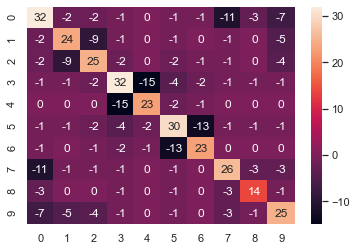

In [133]:
ax1 = sns.heatmap(redL39.astype(int), annot=True, fmt="d")
print(redL39)

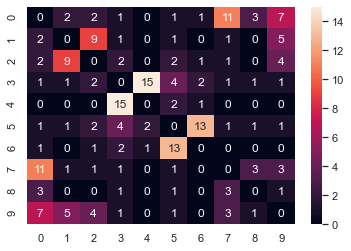

In [134]:
ax2 = sns.heatmap(redA39.astype(int), annot=True, fmt="d")


In [135]:
K = 1
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
# Ome = np.zeros(n)
pi = math.pi
t =  5
nn = 1000
dt = np.linspace(0, t, nn+1)

sigma = 0.05
theta0 = np.zeros(ngnr39)
omega0 = np.zeros(ngnr39)
OMEGA = np.zeros(ngnr39)
model39 = PowerNetworkSolver(theta0,omega0,redA39, ngnr39, D,M,K,OMEGA)

In [136]:
from numpy.random import seed

In [137]:
#generate numerical tracks 
seed(100)
disturbances = normaldisturbances(ngnr39,1,sigma)
# disturbances = np.zeros((1,ngnr39))
# omega0 = np.array([0.666, 1.484, -0.051, -0.153, -0.357, -0.201, 0.255, 0.465, -0.941, -0.012])
sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model39.solkuramoto(sol0,dt)

In [138]:
print(disturbances)

[[-0.39125945  0.07662567  0.25782664 -0.05644641  0.21943     0.11498283
   0.04945728 -0.23926896 -0.04237256  0.05702006]]


In [139]:
print(sol0)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.39125945  0.07662567
  0.25782664 -0.05644641  0.21943     0.11498283  0.04945728 -0.23926896
 -0.04237256  0.05702006]


Text(0.5, 1.0, 'Natural rotation frequencies')

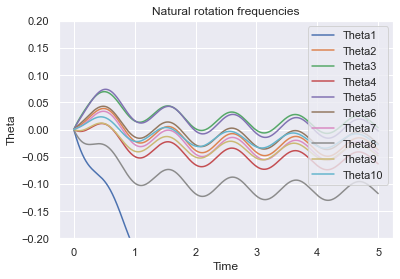

In [140]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="Theta"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Theta")    
plt.ylim(-0.2, 0.2)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

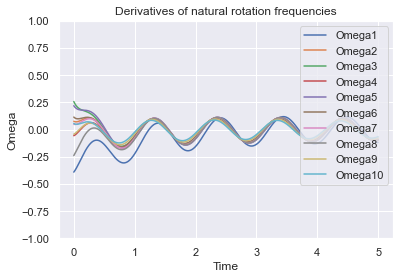

In [141]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]  
    plt.plot(dt, omega, "-", label="Omega"+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega")
plt.ylim(-1, 1)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')

In [122]:
# simulation to calculate failure rates 
check_times = 100
KK =3000#repetition times  
thres = np.array([0.35,0.5])
rates39 = model39.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [105]:
print(rates39['totaltime'])

1.7e+02sec


In [39]:
df39 = pd.DataFrame({'Node': node_list,'RoCoF': rates39['vcheck_omega'] , 'AFV': rates39['vcheck_theta'] ,'AV': rates39['vcheck_any']})
# print(df39.to_latex(index=False))

In [40]:
print(df39)

   Node     RoCoF       AFV        AV
0     1  0.111667  0.444000  0.461000
1     2  0.159667  0.444333  0.468000
2     3  0.139667  0.444000  0.460667
3     4  0.236000  0.442333  0.475667
4     5  0.268333  0.440667  0.483667
5     6  0.241667  0.453333  0.480333
6     7  0.185667  0.439667  0.467333
7     8  0.207333  0.444000  0.487333
8     9  0.196000  0.441333  0.461667
9    10  0.021333  0.449333  0.449333


In [41]:
print(getGenerators(network39))

G0    30
G1    31
G2    32
G3    33
G4    34
G5    35
G6    36
G7    37
G8    38
G9    39
Name: bus, dtype: object


In [42]:
print(getBuses(subnetwork39))

         Pd
1     97.60
2      0.00
3    322.00
4    500.00
5      0.00
6      0.00
7    233.80
8    522.00
9      6.50
10     0.00
11     0.00
12     8.53
13     0.00
14     0.00
15   320.00
16   329.00
17     0.00
18   158.00
19     0.00
20   680.00
21   274.00
22     0.00
23   247.50
24   308.60
25   224.00
26   139.00
27   281.00
28   206.00
29   283.50
30     0.00
31     9.20
32     0.00
33     0.00
34     0.00
35     0.00
36     0.00
37     0.00
38     0.00
39  1104.00


In [43]:
network_test = multi_edge_removing(unG39, [[15,16],[20,34],[23,24]])

[15, 16]
[20, 34]
The graph is not connected without edge (20, 34)
[23, 24]


In [50]:
print(network_test.edges)

[(1, 2.0), (1, 39.0), (2, 3.0), (2, 25.0), (2, 30.0), (3, 4.0), (3, 18.0), (4, 5.0), (4, 14.0), (5, 6.0), (5, 8.0), (6, 7.0), (6, 11.0), (6, 31.0), (7, 8.0), (8, 9.0), (9, 39.0), (10, 11.0), (10, 13.0), (10, 32.0), (11, 12), (12, 13.0), (13, 14.0), (14, 15.0), (16, 17.0), (16, 19.0), (16, 21.0), (16, 24.0), (17, 18.0), (17, 27.0), (19, 20.0), (19, 33.0), (20, 34.0), (21, 22.0), (22, 23.0), (22, 35.0), (23, 36.0), (25, 26.0), (25, 37.0), (26, 27.0), (26, 28.0), (26, 29.0), (28, 29.0), (29, 38.0)]


# 2. Test Case 39, incomplete networks

## 2.1 Removing (20, 34)

In [48]:
G3901 = edge_removing(unG39, [20,34])
A3901, redL3901, redA3901  = kron_reduction(n39, ngnr39, G3901)
model3901 = PowerNetworkSolver(theta0,omega0,redA3901, ngnr39, D,M,K)
rates3901 = model3901.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

The graph is not connected without edge (20, 34)


In [17]:
df3901 = pd.DataFrame({'Node': node_list,'RoCoF': rates3901['vcheck_omega'] , 'AFV': rates3901['vcheck_theta'] ,'AV': rates3901['vcheck_any']})
# print(df3901.to_latex(index=False))

## 2.2 Removing (15, 16)

In [53]:
G3902 = edge_removing(unG39, [15,16])
A3902, redL3902, redA3902  = kron_reduction(n39, ngnr39, G3902)
model3902 = PowerNetworkSolver(theta0,omega0,redA3902, ngnr39, D,M,K)

# rates3902 = model3902.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [54]:
# disturbances = normaldisturbances(ngnr39,1,sigma)
# sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model3902.solkuramoto(sol0,dt)

Text(0.5, 1.0, 'Natural rotation frequencies')

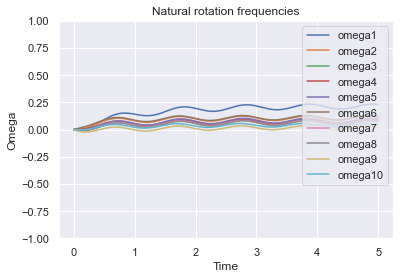

In [55]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-1, 1)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

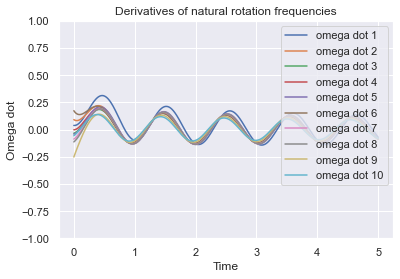

In [56]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-1, 1)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')

In [19]:
df3902 = pd.DataFrame({'Node': node_list,'RoCoF': rates3902['vcheck_omega'] , 'AFV': rates3902['vcheck_theta'] ,'AV': rates3902['vcheck_any']})
# print(df3902.to_latex(index=False))

## 2.3 Removing (23, 24)

In [46]:
G3903 = edge_removing(unG39, [23,24])
A3903, redL3903, redA3903  = kron_reduction(n39, ngnr39, G3903)
model3903 = PowerNetworkSolver(theta0,omega0,redA3903, ngnr39, D,M,K)
rates3903 = model3903.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [21]:
df3903 = pd.DataFrame({'Node': node_list,'RoCoF': rates3903['vcheck_omega'] , 'AFV': rates3903['vcheck_theta'] ,'AV': rates3903['vcheck_any']})
# print(df3903.to_latex(index=False))

In [22]:
pd.options.display.float_format = '{:,.3f}'.format
df39.head()

,Node,RoCoF,AFV,AV
0,1,0.639,0.603,0.686
1,2,0.457,0.200,0.457
2,3,0.425,0.184,0.425
3,4,0.429,0.187,0.429
4,5,0.489,0.272,0.489


In [29]:
df39_merged = [df39,df3901,df3902,df3903]
df39merged = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged)
df39merged = df39merged.append(df39merged.mean(axis = 0), ignore_index=True)
print(df39merged.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.639 &  0.603 & 0.686 &    0.625 &  0.591 & 0.671 &    0.629 &  0.598 & 0.674 &    0.609 &  0.583 & 0.656 \\
 2.000 &    0.457 &  0.200 & 0.457 &    0.461 &  0.218 & 0.461 &    0.451 &  0.208 & 0.451 &    0.433 &  0.207 & 0.433 \\
 3.000 &    0.425 &  0.184 & 0.425 &    0.432 &  0.195 & 0.432 &    0.428 &  0.185 & 0.428 &    0.420 &  0.177 & 0.420 \\
 4.000 &    0.429 &  0.187 & 0.429 &    0.446 &  0.199 & 0.446 &    0.438 &  0.199 & 0.438 &    0.429 &  0.191 & 0.429 \\
 5.000 &    0.489 &  0.272 & 0.489 &    0.487 &  0.272 & 0.487 &    0.482 &  0.289 & 0.483 &    0.480 &  0.266 & 0.480 \\
 6.000 &    0.433 &  0.197 & 0.433 &    0.441 &  0.206 & 0.441 &    0.435 &  0.210 & 0.435 &    0.416 &  0.193 & 0.416 \\
 7.000 &    0.456 &  0.223 & 0.456 &    0.467 &  0.219 & 0.467 &    0.459 &  0.220 & 

## 2.4 Removing [4, 5],[15, 16]

In [40]:
G3904 = multi_edge_removing(unG39, ([4,5],[15,16]))
A3904, redL3904, redA3904  = kron_reduction(n39, ngnr39, G3904)
model3904 = PowerNetworkSolver(theta0,omega0,redA3904, ngnr39, D,M,K)
rates3904 = model3904.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

[4, 5]
[15, 16]


In [41]:
df3904 = pd.DataFrame({'Node': node_list,'RoCoF': rates3904['vcheck_omega'] , 'AFV': rates3904['vcheck_theta'] ,'AV': rates3904['vcheck_any']})
# print(df3901.to_latex(index=False))

In [42]:
print(df3904.head())

   Node  RoCoF   AFV    AV
0     1  0.631 0.616 0.683
1     2  0.458 0.223 0.458
2     3  0.425 0.199 0.425
3     4  0.440 0.211 0.440
4     5  0.489 0.287 0.489


In [63]:
df3904

,Node,RoCoF,AFV,AV
0,1,0.631,0.616,0.683
1,2,0.458,0.223,0.458
2,3,0.425,0.199,0.425
3,4,0.440,0.211,0.440
4,5,0.489,0.287,0.489
5,6,0.434,0.214,0.434
6,7,0.466,0.234,0.466
7,8,0.454,0.223,0.454
8,9,0.358,0.112,0.358
9,10,0.294,0.084,0.294


## 2.5 Removing [4, 5],[15, 16],[4, 14]

In [36]:
G3905 = multi_edge_removing(unG39, ([4,5],[15,16],[4,14]))
A3905, redL3905, redA3905  = kron_reduction(n39, ngnr39, G3905)
model3905 = PowerNetworkSolver(theta0,omega0,redA3905, ngnr39, D,M,K)
rates3905 = model3905.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

[4, 5]
[15, 16]
[4, 14]


In [43]:
df3905 = pd.DataFrame({'Node': node_list,'RoCoF': rates3905['vcheck_omega'] , 'AFV': rates3905['vcheck_theta'] ,'AV': rates3905['vcheck_any']})

In [44]:
df39_merged02 = [df3904,df3905]
df39merged02 = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged02)
df39merged02 = df39merged02.append(df39merged02.mean(axis = 0), ignore_index=True)
print(df39merged02.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.631 &  0.616 & 0.683 &    0.643 &  0.641 & 0.705 \\
 2.000 &    0.458 &  0.223 & 0.458 &    0.462 &  0.247 & 0.462 \\
 3.000 &    0.425 &  0.199 & 0.425 &    0.437 &  0.219 & 0.437 \\
 4.000 &    0.440 &  0.211 & 0.440 &    0.443 &  0.233 & 0.443 \\
 5.000 &    0.489 &  0.287 & 0.489 &    0.497 &  0.314 & 0.498 \\
 6.000 &    0.434 &  0.214 & 0.434 &    0.441 &  0.230 & 0.441 \\
 7.000 &    0.466 &  0.234 & 0.466 &    0.467 &  0.261 & 0.467 \\
 8.000 &    0.454 &  0.223 & 0.454 &    0.471 &  0.256 & 0.471 \\
 9.000 &    0.358 &  0.112 & 0.358 &    0.368 &  0.134 & 0.368 \\
10.000 &    0.294 &  0.084 & 0.294 &    0.304 &  0.096 & 0.304 \\
 5.500 &    0.445 &  0.240 & 0.450 &    0.453 &  0.263 & 0.460 \\
\bottomrule
\end{tabular}



,Node,RoCoF_x,AFV_x,AV_x,RoCoF_y,AFV_y,AV_y
0,1.000,0.631,0.616,0.683,0.643,0.641,0.705
1,2.000,0.458,0.223,0.458,0.462,0.247,0.462
2,3.000,0.425,0.199,0.425,0.437,0.219,0.437
3,4.000,0.440,0.211,0.440,0.443,0.233,0.443
4,5.000,0.489,0.287,0.489,0.497,0.314,0.498
5,6.000,0.434,0.214,0.434,0.441,0.230,0.441
6,7.000,0.466,0.234,0.466,0.467,0.261,0.467
7,8.000,0.454,0.223,0.454,0.471,0.256,0.471
8,9.000,0.358,0.112,0.358,0.368,0.134,0.368
9,10.000,0.294,0.084,0.294,0.304,0.096,0.304


## 2.6 Removing [4, 5]

In [49]:
G3906 = edge_removing(unG39,[4,5])
A3906, redL3906, redA3906  = kron_reduction(n39, ngnr39, G3906)
model3906 = PowerNetworkSolver(theta0,omega0,redA3906, ngnr39, D,M,K)
rates3906 = model3906.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [50]:
df3906 = pd.DataFrame({'Node': node_list,'RoCoF': rates3906['vcheck_omega'] , 'AFV': rates3906['vcheck_theta'] ,'AV': rates3906['vcheck_any']})

## 2.7 Removing [4, 14]

In [51]:
G3907 = edge_removing(unG39,[4,14])
A3907, redL3907, redA3907  = kron_reduction(n39, ngnr39, G3907)
model3907 = PowerNetworkSolver(theta0,omega0,redA3907, ngnr39, D,M,K)
rates3907 = model3907.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [52]:
df3907 = pd.DataFrame({'Node': node_list,'RoCoF': rates3907['vcheck_omega'] , 'AFV': rates3907['vcheck_theta'] ,'AV': rates3907['vcheck_any']})

\begin{tabular}{rrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.641 &  0.629 & 0.696 &    0.634 &  0.600 & 0.678 \\
 2.000 &    0.465 &  0.237 & 0.465 &    0.450 &  0.207 & 0.450 \\
 3.000 &    0.438 &  0.215 & 0.438 &    0.427 &  0.184 & 0.427 \\
 4.000 &    0.447 &  0.215 & 0.447 &    0.436 &  0.193 & 0.436 \\
 5.000 &    0.504 &  0.292 & 0.504 &    0.482 &  0.266 & 0.482 \\
 6.000 &    0.441 &  0.214 & 0.441 &    0.431 &  0.199 & 0.431 \\
 7.000 &    0.470 &  0.251 & 0.470 &    0.465 &  0.222 & 0.465 \\
 8.000 &    0.459 &  0.227 & 0.459 &    0.442 &  0.204 & 0.442 \\
 9.000 &    0.363 &  0.125 & 0.363 &    0.356 &  0.105 & 0.356 \\
10.000 &    0.306 &  0.092 & 0.306 &    0.297 &  0.076 & 0.297 \\
 5.500 &    0.453 &  0.250 & 0.459 &    0.442 &  0.226 & 0.447 \\
\bottomrule
\end{tabular}



                                                   0  \
0     Node  RoCoF   AFV    AV
0     1  0.631 0.61...   
1     Node  RoCoF   AFV    AV
0     1  0.641 0.62...   

                                                   1  
0     Node  RoCoF   AFV    AV
0     1  0.643 0.64...  
1     Node  RoCoF   AFV    AV
0     1  0.634 0.60...  
